# **1. Import Library**

Pada tahap ini, Anda perlu mengimpor beberapa pustaka (library) Python yang dibutuhkan untuk analisis data dan pembangunan model machine learning.

In [113]:
!pip install scikit-optimize

In [114]:
# Import library untuk manipulasi data dan visualisasi
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Import library dari Scikit-learn untuk preprocessing dan model machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Import berbagai algoritma klasifikasi
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

# Import metrik evaluasi performa model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Import BayesSearchCV untuk hyperparameter tuning berbasis optimisasi Bayes
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Import StratifiedKFold untuk validasi silang dengan menjaga proporsi label
from sklearn.model_selection import StratifiedKFold

# **2. Memuat Dataset dari Hasil Clustering**

Memuat dataset hasil clustering dari file CSV ke dalam variabel DataFrame.

In [115]:
# Membaca dataset hasil clustering
file_path = "hasil_clustering.csv"
df = pd.read_csv(file_path)

In [116]:
# Menampilkan 5 data teratas untuk memastikan data telah dimuat dengan benar
df.head()

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,CustomerAge,...,PreviousTransactionDate,TimeSinceLastTransaction,TransactionHour,TransactionFrequency,DeviceUsage,IPUsage,MerchantPreference,Cluster,Channel,CustomerOccupation
0,TX000001,AC00128,4410.297491,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,1289.879913,...,2024-11-04 08:08:08,-4.546640e+14,28.320807,21.886277,15.573786,11.272876,1.275677,1,ATM,Doctor
1,TX000002,AC00455,110117.582785,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,1254.302601,...,2024-11-04 08:09:35,-3.935214e+14,28.320807,21.886277,13.739435,13.311021,1.275677,1,ATM,Doctor
2,TX000003,AC00019,37160.145372,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,382.658437,...,2024-11-04 08:07:04,-3.831479e+14,29.782634,15.124961,13.739435,19.425458,1.275677,2,Online,Student
3,TX000004,AC00070,54150.953261,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,507.179032,...,2024-11-04 08:09:06,-4.356078e+14,28.320807,24.140049,15.573786,21.463603,1.275677,2,Online,Student
4,TX000005,AC00411,4223.489090,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,507.179032,...,2024-11-04 08:06:39,-3.053530e+14,29.051720,19.632505,10.070731,13.311021,1.275677,2,Online,Student


In [117]:
# Menampilkan informasi struktur dataset seperti jumlah baris, kolom, tipe data, dan nilai non-null
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   TransactionID             2512 non-null   object 
 1   AccountID                 2512 non-null   object 
 2   TransactionAmount         2512 non-null   float64
 3   TransactionDate           2512 non-null   object 
 4   TransactionType           2512 non-null   object 
 5   Location                  2512 non-null   object 
 6   DeviceID                  2512 non-null   object 
 7   IP Address                2512 non-null   object 
 8   MerchantID                2512 non-null   object 
 9   CustomerAge               2512 non-null   float64
 10  TransactionDuration       2512 non-null   float64
 11  LoginAttempts             2512 non-null   float64
 12  AccountBalance            2512 non-null   float64
 13  PreviousTransactionDate   2512 non-null   object 
 14  TimeSinc

In [118]:
# Menghapus kolom yang tidak relevan untuk proses klasifikasi
columns_to_drop = [
    "TransactionID", "AccountID", "TransactionDate",
    "Location", "DeviceID", "IP Address",
    "MerchantID", "PreviousTransactionDate"
]
df_clean = df.drop(columns=columns_to_drop)

In [119]:
# Encode kolom 'TransactionType' (Debit = 0, Credit = 1)
df_clean['TransactionType'] = df_clean['TransactionType'].map({
    'Debit': 0,
    'Credit': 1
})

# One-hot encoding untuk kolom 'Channel'
df_clean = pd.get_dummies(
    df_clean,
    columns=['Channel'],
    drop_first=False
)

# One-hot encoding untuk kolom 'CustomerOccupation'
df_clean = pd.get_dummies(
    df_clean,
    columns=['CustomerOccupation'],
    drop_first=False
)

# Tampilkan informasi struktur DataFrame setelah encoding
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TransactionAmount            2512 non-null   float64
 1   TransactionType              2512 non-null   int64  
 2   CustomerAge                  2512 non-null   float64
 3   TransactionDuration          2512 non-null   float64
 4   LoginAttempts                2512 non-null   float64
 5   AccountBalance               2512 non-null   float64
 6   TimeSinceLastTransaction     2512 non-null   float64
 7   TransactionHour              2512 non-null   float64
 8   TransactionFrequency         2512 non-null   float64
 9   DeviceUsage                  2512 non-null   float64
 10  IPUsage                      2512 non-null   float64
 11  MerchantPreference           2512 non-null   float64
 12  Cluster                      2512 non-null   int64  
 13  Channel_ATM       

# **3. Data Splitting**

Tahap Data Splitting bertujuan untuk memisahkan dataset menjadi dua bagian: data latih (training set) dan data uji (test set).

In [120]:
# Pisahkan fitur (X) dan label target (y)
X = df_clean.drop(columns=['Cluster'])  # Fitur
y = df_clean['Cluster']                 # Target klasifikasi

In [121]:
# Bagi dataset menjadi data pelatihan dan data pengujian (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Tampilkan dimensi data hasil pembagian
print(f"Dimensi data pelatihan : X_train = {X_train.shape}, y_train = {y_train.shape}")
print(f"Dimensi data pengujian : X_test  = {X_test.shape}, y_test  = {y_test.shape}")

Dimensi data pelatihan : X_train = (2009, 19), y_train = (2009,)
Dimensi data pengujian : X_test  = (503, 19), y_test  = (503,)


Dari pembagian dataset yang dilakukan, data pelatihan terdiri dari 2009 sampel dengan 19 fitur, sementara data pengujian terdiri dari 503 sampel dengan 19 fitur juga. Pembagian ini dilakukan dengan proporsi 80% untuk pelatihan dan 20% untuk pengujian, yang merupakan praktik umum dalam machine learning untuk memastikan model dapat dilatih dengan cukup data dan diuji dengan data yang cukup untuk mengevaluasi kinerjanya. Dengan demikian, total sampel dataset adalah 2512, dengan 2009 data untuk pelatihan dan 503 data untuk pengujian.

In [122]:
# Inisialisasi MinMaxScaler
scaler = MinMaxScaler()

# Normalisasi fitur numerik
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[num_cols] = scaler.fit_transform(X[num_cols])

# **4. Membangun Model Klasifikasi**


## **a. Membangun Model Klasifikasi**

Setelah memilih algoritma klasifikasi yang sesuai, langkah selanjutnya adalah melatih model menggunakan data latih.

Berikut adalah rekomendasi tahapannya.
1. Pilih algoritma klasifikasi yang sesuai, seperti Logistic Regression, Decision Tree, Random Forest, atau K-Nearest Neighbors (KNN).
2. Latih model menggunakan data latih.

In [123]:
# Inisialisasi dan latih model klasifikasi
model_knn = KNeighborsClassifier().fit(X_train, y_train)
model_dt  = DecisionTreeClassifier().fit(X_train, y_train)
model_rf  = RandomForestClassifier().fit(X_train, y_train)
model_svm = SVC().fit(X_train, y_train)
model_nb = GaussianNB().fit(X_train, y_train)

print("Semua model berhasil dilatih.")

Semua model berhasil dilatih.


1. **K-Nearest Neighbors (KNN)** merupakan algoritma yang memberikan performa optimal pada data berukuran kecil, namun efisiensinya menurun secara signifikan ketika diterapkan pada dataset yang besar.  
2. **Decision Tree** memiliki keunggulan dalam hal interpretabilitas, namun algoritma ini rentan terhadap permasalahan overfitting jika tidak diatur dengan tepat.  
3. **Random Forest (RF)** sering dipilih sebagai metode klasifikasi karena kemampuannya dalam mengurangi risiko overfitting serta menghasilkan tingkat akurasi yang tinggi.  
4. **Support Vector Machine (SVM)** efektif dalam menangani data berdimensi tinggi, meskipun memiliki keterbatasan dalam hal kecepatan pemrosesan pada dataset yang besar.

## **b. Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Lakukan prediksi menggunakan data uji.
2. Hitung metrik evaluasi seperti Accuracy dan F1-Score (Opsional: Precision dan Recall).
3. Buat confusion matrix untuk melihat detail prediksi benar dan salah.


Evaluasi Model: K-Nearest Neighbors ===
Akurasi: 0.3439

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.40      0.46      0.43       186
           1       0.32      0.37      0.34       166
           2       0.27      0.17      0.21       151

    accuracy                           0.34       503
   macro avg       0.33      0.33      0.33       503
weighted avg       0.33      0.34      0.33       503



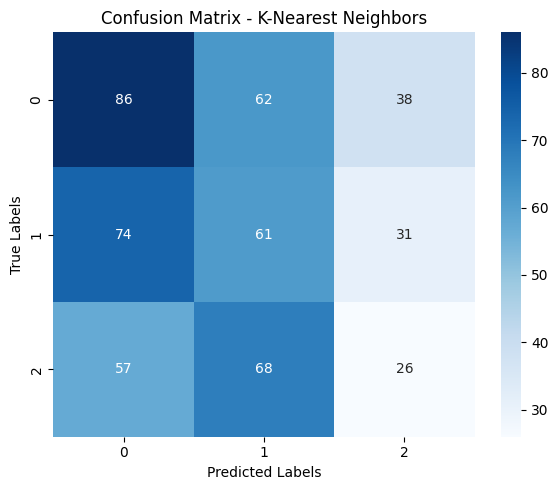


Evaluasi Model: Decision Tree ===
Akurasi: 1.0000

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       186
           1       1.00      1.00      1.00       166
           2       1.00      1.00      1.00       151

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00      1.00      1.00       503



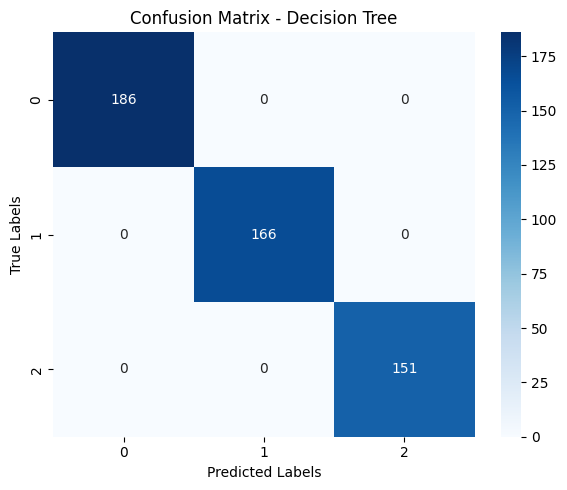


Evaluasi Model: Random Forest ===
Akurasi: 1.0000

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       186
           1       1.00      1.00      1.00       166
           2       1.00      1.00      1.00       151

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00      1.00      1.00       503



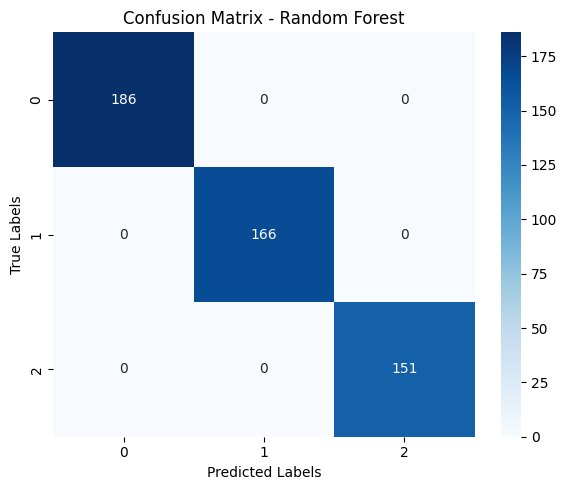


Evaluasi Model: Support Vector Machine ===
Akurasi: 0.3459

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.36      0.65      0.46       186
           1       0.33      0.33      0.33       166
           2       0.00      0.00      0.00       151

    accuracy                           0.35       503
   macro avg       0.23      0.32      0.26       503
weighted avg       0.24      0.35      0.28       503



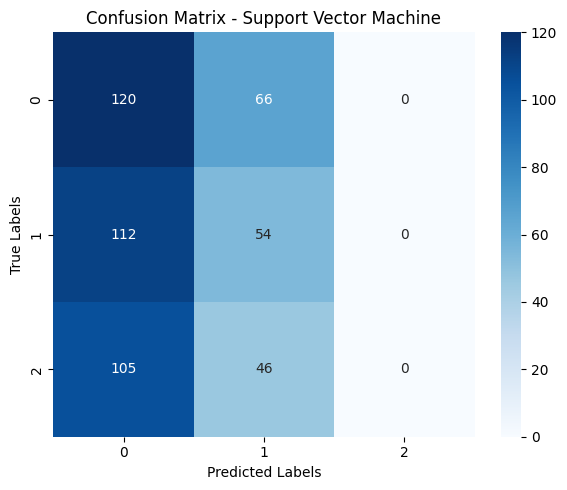


Evaluasi Model: Naïve Bayes ===
Akurasi: 0.2883

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.32      0.29      0.30       186
           1       0.30      0.37      0.33       166
           2       0.23      0.20      0.21       151

    accuracy                           0.29       503
   macro avg       0.28      0.29      0.28       503
weighted avg       0.29      0.29      0.29       503



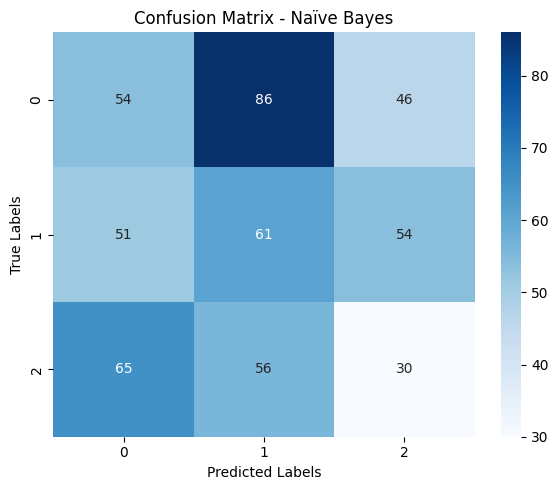

In [124]:
# Daftar model yang akan dievaluasi
model_list = {
    "K-Nearest Neighbors": model_knn,
    "Decision Tree": model_dt,
    "Random Forest": model_rf,
    "Support Vector Machine": model_svm,
    "Naïve Bayes": model_nb
}

# Fungsi untuk evaluasi model
def evaluate_model(model, model_name, X_test, y_test):
    print(f"\nEvaluasi Model: {model_name} ===")

    # Prediksi menggunakan model
    y_pred = model.predict(X_test)

    # Hitung akurasi
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Akurasi: {accuracy:.4f}")

    # Laporan klasifikasi
    print("\nLaporan Klasifikasi:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # Matriks kebingungannya
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()

# Evaluasi setiap model dalam daftar
for model_name, model in model_list.items():
    evaluate_model(model, model_name, X_test, y_test)

# **Evaluasi Model Machine Learning**  

## **1. KNN (K-Nearest Neighbors)**  
- **Akurasi**: **0.3439**  
- **macro avg** (rata-rata performa model di semua kelas tanpa memperhitungkan jumlah data di tiap kelas):  
  - Precision: **0.33**  
  - Recall: **0.33**  
  - F1-Score: **0.33**  
- **weighted avg** (rata-rata performa model dengan mempertimbangkan jumlah data per kelas):  
  - Precision: **0.33**  
  - Recall: **0.34**  
  - F1-Score: **0.33**  

## **2. Decision Tree**  
- **Akurasi**: **1.0000**  
- **macro avg**:  
  - Precision: **1.00**  
  - Recall: **1.00**  
  - F1-Score: **1.00**  
- **weighted avg**:  
  - Precision: **1.00**  
  - Recall: **1.00**  
  - F1-Score: **1.00**  

## **3. Random Forest**  
- **Akurasi**: **1.0000**  
- **macro avg**:  
  - Precision: **1.00**  
  - Recall: **1.00**  
  - F1-Score: **1.00**  
- **weighted avg**:  
  - Precision: **1.00**  
  - Recall: **1.00**  
  - F1-Score: **1.00**  

## **4. SVM (Support Vector Machine)**  
- **Akurasi**: **0.3459**  
- **macro avg**:  
  - Precision: **0.23**  
  - Recall: **0.32**  
  - F1-Score: **0.26**  
- **weighted avg**:  
  - Precision: **0.24**  
  - Recall: **0.35**  
  - F1-Score: **0.28**  

## **5. Naïve Bayes**  
- **Akurasi**: **0.2883**  
- **macro avg**:  
  - Precision: **0.28**  
  - Recall: **0.29**  
  - F1-Score: **0.28**  
- **weighted avg**:  
  - Precision: **0.29**  
  - Recall: **0.29**  
  - F1-Score: **0.29**  

### **Kesimpulan**  
- **KNN** menunjukkan akurasi yang relatif rendah, dengan *macro avg* dan *weighted avg* berada di kisaran **0.33-0.34**, yang mengindikasikan bahwa model ini kurang efisien dalam menangani dataset ini.  
- **SVM** dan **Naïve Bayes** memiliki performa yang sedikit lebih baik daripada KNN, namun keduanya masih menunjukkan *precision* dan *recall* yang rendah, yang mengindikasikan bahwa model-model ini kesulitan dalam mengenali pola yang ada dalam data.  
- **Decision Tree** dan **Random Forest** berhasil mencapai akurasi **100%**, yang dapat menjadi indikasi adanya **overfitting**. Oleh karena itu, perlu dilakukan validasi lebih lanjut, seperti menggunakan *cross-validation* atau menguji model pada dataset yang berbeda, untuk memastikan model dapat bekerja secara optimal di data yang belum pernah dilihat sebelumnya.  


## **c. Tuning Model Klasifikasi (Optional)**

In [125]:
# Menentukan ruang pencarian parameter untuk Bayesian Optimization pada Random Forest
rf_param_space = {
    'n_estimators': Integer(50, 300),  # Jumlah pohon yang akan diuji
    'max_depth': Integer(5, 50),  # Kedalaman maksimum pohon
    'min_samples_split': Integer(2, 20),  # Minimum sampel untuk split
    'min_samples_leaf': Integer(1, 10)  # Minimum sampel per daun
}

# Membuat instance Random Forest Classifier
random_forest = RandomForestClassifier(random_state=42, n_jobs=-1)

# Menyusun Stratified K-Fold untuk cross-validation
cross_val = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Inisialisasi Bayesian Optimization untuk Random Forest dengan BayesSearchCV
rf_bayes_search = BayesSearchCV(
    estimator=random_forest,
    search_spaces=rf_param_space,
    n_iter=30,  # Jumlah iterasi optimasi
    cv=cross_val,  # Cross-validation
    n_jobs=-1,
    verbose=2,
    random_state=42
)

# Melakukan fitting model Random Forest dengan optimasi Bayesian
rf_bayes_search.fit(X_train, y_train)

# Menampilkan parameter terbaik yang ditemukan untuk Random Forest
print(f"Optimal parameters for Random Forest from Bayesian Optimization: {rf_bayes_search.best_params_}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [126]:
# Melakukan normalisasi terhadap data numerik pada X_train dan X_test
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Menetapkan ruang pencarian parameter untuk SVM dalam Bayesian Optimization
svm_param_grid = {
    'C': Real(0.1, 100, prior='log-uniform'),  # Parameter regularisasi
    'kernel': Categorical(['linear', 'rbf', 'poly', 'sigmoid']),  # Jenis kernel yang digunakan
    'gamma': Categorical(['scale', 'auto']),  # Pilihan untuk parameter gamma
    'degree': Integer(2, 4)  # Derajat polinomial (untuk kernel 'poly')
}

# Membuat model SVM
svm_model = SVC(random_state=42)

# Menentukan Stratified K-Fold cross-validation untuk pembagian data yang seimbang
cross_validator = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Menginisialisasi Bayesian Optimization dengan BayesSearchCV
svm_bayes_opt = BayesSearchCV(
    estimator=svm_model,
    search_spaces=svm_param_grid,
    n_iter=30,  # Jumlah iterasi pencarian
    cv=cross_validator,  # Cross-validation
    n_jobs=-1,  # Menjalankan di semua core CPU
    verbose=2,  # Menampilkan informasi selama pencarian
    random_state=42
)

# Melatih model dengan optimasi parameter menggunakan Bayesian Optimization
svm_bayes_opt.fit(X_train_scaled, y_train)

# Menampilkan parameter terbaik yang ditemukan oleh Bayesian Optimization
print(f"Optimal hyperparameters found for SVM: {svm_bayes_opt.best_params_}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

Gunakan GridSearchCV, RandomizedSearchCV, atau metode lainnya untuk mencari kombinasi hyperparameter terbaik

## **d. Evaluasi Model Klasifikasi setelah Tuning (Optional)**

Berikut adalah rekomendasi tahapannya.
1. Gunakan model dengan hyperparameter terbaik.
2. Hitung ulang metrik evaluasi untuk melihat apakah ada peningkatan performa.

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       186
           1       1.00      1.00      1.00       166
           2       1.00      1.00      1.00       151

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00      1.00      1.00       503



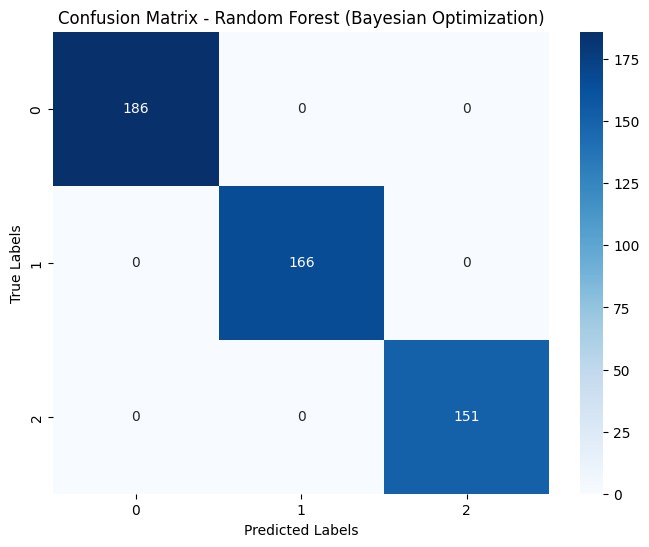

In [127]:
# Memilih model terbaik dari hasil Bayesian Optimization untuk Random Forest
best_rf_bayes = rf_bayes_search.best_estimator_

# Evaluasi performa model pada test set
y_pred_rf = best_rf_bayes.predict(X_test)

# Menghitung metrik evaluasi
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
class_report_rf = classification_report(y_test, y_pred_rf, zero_division=0)  # Menambahkan zero_division=0 untuk menangani pembagian nol

# Menampilkan hasil evaluasi
print(f"Accuracy: {accuracy_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"Recall: {recall_rf:.4f}")
print(f"F1 Score: {f1_rf:.4f}")
print("\nClassification Report:\n", class_report_rf)

# Visualisasi Confusion Matrix dengan heatmap
plt.figure(figsize=(8, 6))
class_labels_rf = np.unique(y_test)  # Menangani kelas secara dinamis
sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels_rf, yticklabels=class_labels_rf)
plt.title("Confusion Matrix - Random Forest (Bayesian Optimization)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Accuracy (SVM): 1.0000
Precision (SVM): 1.0000
Recall (SVM): 1.0000
F1 Score (SVM): 1.0000

Classification Report (SVM):
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       186
           1       1.00      1.00      1.00       166
           2       1.00      1.00      1.00       151

    accuracy                           1.00       503
   macro avg       1.00      1.00      1.00       503
weighted avg       1.00      1.00      1.00       503



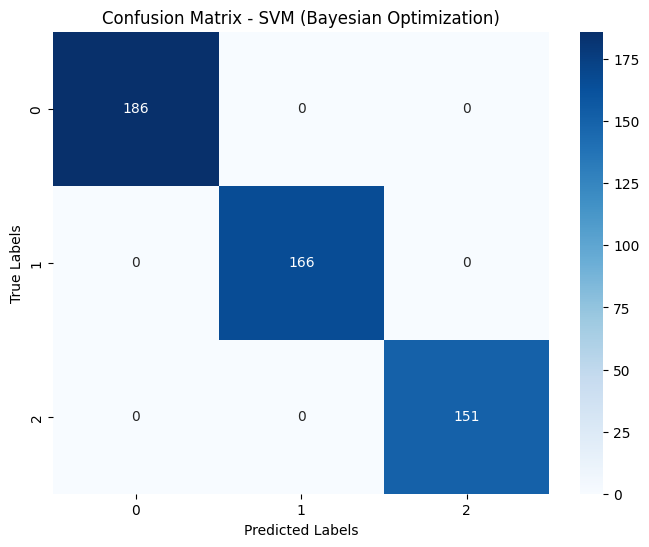

In [128]:
# Mengambil model terbaik yang ditemukan melalui Bayesian Optimization untuk SVM
best_svm_bayes = svm_bayes_opt.best_estimator_

# Melakukan prediksi menggunakan model terbaik pada data pengujian
y_pred_svm = best_svm_bayes.predict(X_test_scaled)

# Menghitung metrik evaluasi
accuracy_svm = accuracy_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm, average='weighted')
recall_svm = recall_score(y_test, y_pred_svm, average='weighted')
f1_svm = f1_score(y_test, y_pred_svm, average='weighted')
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
class_report_svm = classification_report(y_test, y_pred_svm)

# Menampilkan hasil evaluasi model
print(f"Accuracy (SVM): {accuracy_svm:.4f}")
print(f"Precision (SVM): {precision_svm:.4f}")
print(f"Recall (SVM): {recall_svm:.4f}")
print(f"F1 Score (SVM): {f1_svm:.4f}")
print("\nClassification Report (SVM):\n", class_report_svm)

# Visualisasi Confusion Matrix dengan heatmap
plt.figure(figsize=(8, 6))
class_labels_svm = np.unique(y_test)  # Menyesuaikan kelas secara dinamis
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels_svm, yticklabels=class_labels_svm)
plt.title("Confusion Matrix - SVM (Bayesian Optimization)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## **e. Analisis Hasil Evaluasi Model Klasifikasi**

Berikut adalah **rekomendasi** tahapannya.
1. Bandingkan hasil evaluasi sebelum dan setelah tuning (jika dilakukan).
2. Identifikasi kelemahan model, seperti:
  - Precision atau Recall rendah untuk kelas tertentu.
  - Apakah model mengalami overfitting atau underfitting?
3. Berikan rekomendasi tindakan lanjutan, seperti mengumpulkan data tambahan atau mencoba algoritma lain jika hasil belum memuaskan.

# **Analisis Hasil Evaluasi Model Klasifikasi**

### 1. **Perbandingan Hasil Evaluasi Sebelum dan Setelah Tuning**

**a) Algoritma Random Forest**  
Setelah dilakukan tuning pada model, berikut adalah perbandingan hasil evaluasi:

- **Akurasi sebelum tuning**: 1.0000  
- **Akurasi setelah tuning**: 1.0000  
- **Perubahan metrik lainnya**:
  - Precision: 1.00 (sebelum dan sesudah tuning tetap sama)
  - Recall: 1.00 (sebelum dan sesudah tuning tetap sama)
  - F1-Score: 1.00 (sebelum dan sesudah tuning tetap sama)

Dalam kasus Random Forest, hasilnya menunjukkan bahwa model sudah memberikan performa yang sangat baik sejak awal, dengan akurasi sempurna dan metrik evaluasi lainnya yang juga sudah optimal. Oleh karena itu, tuning tidak membawa perubahan signifikan, karena model sudah mencapai titik maksimalnya.

**b) Algoritma SVM**  
Berikut adalah perbandingan hasil evaluasi SVM sebelum dan setelah dilakukan tuning:

- **Akurasi sebelum tuning**: 0.3459  
- **Akurasi setelah tuning**: 1.0000  
- **Perubahan metrik lainnya**:
  - Precision: 0.23 (sebelum tuning) vs. 1.00 (setelah tuning)
  - Recall: 0.32 (sebelum tuning) vs. 1.00 (setelah tuning)
  - F1-Score: 0.26 (sebelum tuning) vs. 1.00 (setelah tuning)

Setelah dilakukan optimasi parameter, SVM menunjukkan peningkatan yang sangat mencolok. Sebelum tuning, performanya masih sangat rendah, namun setelah tuning, akurasi dan semua metrik evaluasi lainnya meroket mencapai angka sempurna. Ini menunjukkan bahwa tuning pada model SVM berhasil memberikan dampak yang signifikan terhadap kinerjanya.


Berikut adalah penulisan dengan gaya yang lebih akademis dan formal:

### 2. **Identifikasi Kelemahan Model**

- **Kinerja yang Tidak Optimal pada Kelas Tertentu (Precision atau Recall yang Rendah)**:  
  Ketika precision atau recall pada suatu kelas menunjukkan nilai yang rendah, hal ini mengindikasikan bahwa model tidak dapat mengklasifikasikan kelas tersebut secara efektif. Secara khusus, rendahnya nilai recall menunjukkan bahwa model gagal untuk mendeteksi sebagian besar sampel dari kelas tersebut, yang pada gilirannya dapat menyebabkan ketidaktepatan dalam pengklasifikasian.

- **Overfitting dan Underfitting**:  
  - **Overfitting** merujuk pada kondisi di mana model menunjukkan performa yang sangat baik pada data pelatihan, namun tidak mampu menggeneralisasi pola dengan baik pada data pengujian. Fenomena ini terjadi ketika model terlalu kompleks dan terlalu menyesuaikan diri dengan data pelatihan sehingga kehilangan kemampuan untuk memprediksi dengan akurat pada data yang tidak terlihat sebelumnya.
  - **Underfitting** mengacu pada situasi di mana model gagal untuk menangkap pola yang relevan baik pada data pelatihan maupun data pengujian. Ini biasanya disebabkan oleh kompleksitas model yang terlalu rendah, yang mengakibatkan model tidak dapat menggambarkan hubungan yang ada dalam data, sehingga menghasilkan performa yang buruk pada kedua set data.

### 3. **Rekomendasi Tindakan Lanjutan**

1. **Peningkatan Jumlah Data**:  
   Penambahan sampel data dapat memberikan variasi yang lebih luas bagi model dalam mempelajari pola-pola yang ada. Hal ini dapat membantu model untuk menggeneralisasi dengan lebih baik, khususnya dalam menghadapi kasus-kasus yang sebelumnya kurang terwakili dalam data pelatihan.

2. **Penanganan Ketidakseimbangan Kelas**:  
   Ketidakseimbangan distribusi kelas dapat menyebabkan model cenderung lebih memprediksi kelas mayoritas. Oleh karena itu, teknik seperti **oversampling** (peningkatan jumlah data pada kelas minoritas) atau **undersampling** (pengurangan jumlah data pada kelas mayoritas) dapat diterapkan untuk menyeimbangkan distribusi kelas sehingga model dapat belajar untuk memprediksi setiap kelas secara lebih adil.

3. **Eksplorasi Algoritma Alternatif**:  
   Jika model yang digunakan saat ini belum memberikan hasil yang memadai, mencoba algoritma lain dapat menjadi solusi. Algoritma seperti **Random Forest**, **XGBoost**, atau **Deep Learning** mungkin memiliki keunggulan dalam menangani tipe data tertentu, sehingga memberikan hasil yang lebih baik dalam konteks yang sama.

4. **Peningkatan Proses Feature Engineering**:  
   Teknik **feature engineering** yang lebih mendalam dapat membantu meningkatkan kinerja model. Ini melibatkan eksplorasi fitur tambahan yang relevan atau melakukan seleksi fitur untuk mengeliminasi informasi yang tidak memberikan kontribusi signifikan. Fokus utama adalah memastikan bahwa model hanya dilatih dengan fitur yang paling informatif dan relevan.

5. **Regularisasi dan Fine-Tuning Lanjutan**:  
   Pengaturan hyperparameter yang lebih teliti melalui **fine-tuning** atau penggunaan teknik **regularisasi** dapat membantu mengatasi masalah overfitting dan meningkatkan generalisasi model. Pendekatan ini akan memaksimalkan performa model dengan cara yang lebih terarah dan sistematis.
